# Solving Multi-Armed Bandit Problem through epsilon-Greedy Algorithm

**Outline**

* [What is Multi-Armed Bandit Problem](#problem)
* [Epsilon-Greedy Algorithm](#epsilon)
* [Implement Epsilon-Greedy Algorithm](#implement)
* [The Cons of Epsilon-Greedy Algorithm](#cons)
* [Reference](#refer)

In [1]:
%matplotlib inline
%reload_ext watermark
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

%watermark -a 'Johnny' -d -t -v -p numpy,pandas,matplotlib,seaborn

Johnny 2019-01-30 17:43:41 

CPython 3.6.8
IPython 6.1.0

numpy 1.13.3
pandas 0.20.3
matplotlib 2.1.0
seaborn 0.9.0


---

## <a id='problem'>What is Multi-Armed Bandit Problem</a>

Imagine when you are in a Casino, there are many different slot machines that you can play some simple slot games. 
In this hypothetical casino, there’s only one type of game: a slot machine, which is also sometimes called a one-armed bandit because of its propensity to take your money. While this casino only features slot machines, it could still be an interesting place to visit because there are many different slot machines, each of which has a different payout schedule. For example, some of the slot machines in this hypothetical casino might pay out \$5 on 1 out of 100 pulls, while other machines would pay out \$25 on 1 out of 1,000 pulls. In this case, what should we do to achieve the following two things at the same time?
1. **Learn about new arms**
2. **Earn as much reward as possible by pulling on arms you already know are good choices**

This problem is originally came up by some mathematicians, and for some reasons, they decided to treat the different slot machines in their thought experiment as if they were one giant slot machine that had many arms. This led them to refer to the options in their problem as arms. It also led them to call this thought experiment the Multiarmed Bandit Problem. To this day, we still call these algorithms bandit algorithms, knowing the historical names helps to explain why we refer to the options as arms.

The challenge of a bandit problem are
* We’re facing a complicated slot machine, called a bandit, that has a set of N arms that we can pull on.
* When pulled, any given arm will output a reward. But these rewards aren’t reliable, which is why we’re gambling: Arm 1 might give us 1 unit of reward only 1% of the time, while Arm 2 might give us 1 unit of reward only 3% of the time. Any specific pull of any specific arm is risky.
* Not only is each pull of an arm risky, we also don’t start off knowing what the reward rates are for any of the arms. We have to figure this out experimentally by actually pulling on the unknown arms.
* We only find out about the reward that was given out by the arm we actually pulled. Whichever arm we pull, we miss out on information about the other arms that we didn’t pull. Just like in real life, you only learn about the path you took and not the paths you could have taken.
* Every time we experiment with an arm that isn’t the best arm, we lose reward because we could, at least in principle, have pulled on a better arm.

To solve a bandit problem, we some how need to decide between how much we want to **explore** new options and **exploit** the current best option.  

There is a wide range of application in terms of fitting this senerio to different problems. For example
* Amplero, a start-up company in Seattle, focus on the revolution of multi-armed bandit experimentation coupled with machine learning, highlighting what it means for today’s marketer, and specifically the marketer’s ability to directly impact business KPIs and customer lifetime value. 
    * [Marketing and multi-armed bandit experimentation](https://www.amplero.com/blog/posts/marketing-and-multi-armed-bandit-experimentation/)
* Netflix leverage multi-armed bandit algorithms to select the best artwork for a title. 
    * [Selecting the best artwork for videos through A/B testing](https://medium.com/netflix-techblog/selecting-the-best-artwork-for-videos-through-a-b-testing-f6155c4595f6)
    * [Artwork Personalization at Netflix](https://medium.com/netflix-techblog/artwork-personalization-c589f074ad76)
    
Multi-armed bandit experimentation can be thought of as an alternative to A/B testing and there is definitely pro and cons of using either one, which we'll discuss later in the post.

## <a id='epsilon'>Epsilon-Greedy Algorithm</a>

Let’s flesh the idea of the algorithm out using an example of changing the color of a website’s logo to increase revenue. We’ll assume that Deb is debating between two colors, green and red, and that she wants to find the one color that maximizes the odds that a new visitor to her site will be converted into a registered user. The epsilon-Greedy algorithm attempts to find the best color logo using the following procedure (shown diagrammatically in Figure 3-1), which is applied to each new potential customer sequentially:

> * When a new visitor comes to the site, the algorithm flips a coin that comes up tails with probability epsilon.
> * If the coin comes up heads, the algorithm is going to exploit. To exploit, the algorithm looks up the historical conversion rates for both the green and red logos in whatever data source it uses to keep track of things. After determining which color had the highest success rate in the past, the algorithm decides to show the new visitor the color that’s been most successful historically.
> * If, instead of coming up heads, the coin comes up tails, the algorithm is going to explore. Since exploration involves randomly experimenting with the two colors being considered, the algorithm needs to flip a second coin to choose between them. Unlike the first coin, we’ll assume that this second coin comes up head 50% of the time. Once the second coin is flipped, the algorithm can move on with the last step of the procedure:
    * If the second coin comes up heads, show the new visitor the green logo.
    * If the second coin comes up tails, show the new visitor the red logo.

This is basically how the algorithm work. It can also be described in the following way:
> * With probability 1 – epsilon, the epsilon-Greedy algorithm exploits the best known option.
* With probability epsilon / N, the epsilon-Greedy algorithm explores the best known option.
* With probability epsilon / N, the epsilon-Greedy algorithm explores the worst known option.

## <a id='implement'>Implement Epsilon-Greedy Algorithm</a>

In [2]:
def ind_max(x):
    """return the index with the maximum value"""
    m = max(x)
    return x.index(m)   

class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        """
        Parameters
        ----------
        epsilon:             
            If we set epsilon = 0.1, then we’ll explore the available arms on 10% of our pulls.
        counts:             
            If there are two arms, Arm 1 and Arm 2, which have both been played twice, then we’ll set counts = [2, 2].
        values: 
            A vector with the average amount of reward we’ve gotten when playing each of the N arms available to us. 
            If Arm 1 gave us 1 unit of reward on one play and 0 on another play, while Arm 2 gave us 0 units of reward on both plays, 
            then we’ll set values = [0.5, 0.0]
        """
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        """
        initialization methods that let you reset these variables to their proper blank slate states before letting the algorithms loose
        """
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return

    def select_arm(self):
        """
        the logic of epsilon-greedy algorithm
        """
        if random.random() > self.epsilon:
            # exploit
            output = ind_max(self.values)
        else:
            # explore
            output = random.randrange(len(self.values))
        return output
    
    def update(self, chosen_arm, reward):
        """update the count, value for the chosen arm"""
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In order to reasonably simulate what might happen if you were to deploy an epsilon-Greedy algorithm in production, we need to set up some hypothetical arms. We’re going to focus on a very simple type of simulated arm that’s easy to implement correctly. This hypothetical arm will let us simulate settings like:

* **Optimizing click-through rates for ads**: Every time we show someone an ad, we’ll imagine that there’s a fixed probability that they’ll click on the ad. The bandit algorithm will then estimate this probability and try to decide on a strategy for showing ads that maximizes the click-through rate. **The goal is to decide which ad we should show in a certain spot on our website**.
* **Conversion rates for new users**: Every time a new visitor comes to our site who isn’t already a registered user, we’ll imagine that there’s a fixed probability that they’ll register as a user after seeing the landing page. We’ll then estimate this probability and try to decide on a strategy for maximizing our conversion rate. **The goal is to decide which landing page we should use in order to reach the highest conversion rate**.

Our simulated arm is going to be called a Bernoulli arm. Calling this type of an arm a Bernoulli arm is just a jargony way of saying that we’re dealing with an arm that rewards you with a value of 1 some percentage of the time and rewards you with a value of 0 the rest of the time. This 0/1 framework is a very simple way to simulate situations like click-throughs or user signups: the potential user arrives at your site; you select an arm for them in which you, for example, show them one specific color logo; finally, they either do sign up for the site (and give you reward 1) or they don’t (and give you reward 0). If 2% of people who see a red logo sign up and 5% of people who see a green logo sign up, then you can abstract away the details and talk about two arms: one arm outputs 1 unit of reward 2% of the time, the other arm outputs 1 unit of reward 5% of the time. This situation is what we call a Bernoulli arm. We implement it in Python as follows:

In [4]:
class BernoulliArm():
    """simulate an arm with a probability as input and output the reward as either 1 or 0"""
    def __init__(self, p):
        """p: the probability of getting a reward of value 1"""
        self.p = p

    def draw(self):
        if random.random() > self.p:
            reward = 0.0
        else:
            reward = 1.0            
        return reward

In [5]:
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
print(means)

[0.1, 0.1, 0.1, 0.1, 0.9]


In [6]:
# this simulate how we select arms manually for 4 times
# the output indicate the reward
print(arms[0].draw())
print(arms[4].draw())
print(arms[2].draw())
print(arms[4].draw())

0.0
1.0
0.0
1.0


In [7]:
def test_algorithm(algo, arms, num_sims, horizon):
    """
    Parameters
    ----------
    algo(object): the algorithm object that we want to use
    arms(object): an object simulating an arms (input: p; output: reward)
    num_sims(int): the number of simulation that we want to run
    horizon(int): the number of pulls available for each simulation    
    """
    # initializing the value of the vectors as 0 and update as 1 later if we have reward for that particular sim and horizon
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]

    # initial num_sims number of algo objects
    for sim in range(num_sims):
#         print("    #sim"+str(sim))
        sim = sim + 1
        algo.initialize(len(arms))

        # for each simulation, we have #horizon times to pull the arms with a goal of maximizing the reward
        for t in range(horizon):
#             print("        #time"+str(t))
            # get the index of this specific sim and horizon
            t = t + 1
            index = (sim - 1) * horizon + t - 1
            sim_nums[index] = sim
            times[index] = t

            # based on input algo, choose which arm to pull
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm

            # get and update the reward of that specific pull
            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward

            # update the cumulative reward in order to see what the actual reward get by the end of each simulation
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward

            algo.update(chosen_arm, reward)

    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [8]:
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

# doing simulation using different epsilon (the probabilty to explore, the higher it is, the more "conservative" it is)
f = open("_data/standard_results.tsv", "w")

for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
#     print("epsilon"+str(epsilon))
    algo = EpsilonGreedy(epsilon, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, 5000, 250) # doing 5000 simulation with each time having 250 try
    for i in range(len(results[0])):
        f.write(str(epsilon) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
#         print(str(epsilon) + "\t")
#         print("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")            

f.close()

### Analyzing Results from the Simulation

In [11]:
# read date
data = pd.read_csv("_data/standard_results.tsv", 
                   sep='\t', 
                   names=['epsilon', 'sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards'])

> **Approach 1: Track the Average Reward at Each Point in Time**

In [33]:
df_reward = data.groupby(['epsilon','times'],as_index=False).agg({'rewards':'sum', 'cumulative_rewards':'mean'}).copy()
df_reward['avg_rewards'] = df_reward['rewards']/5000
df_reward['epsilon'] = df_reward['epsilon'].astype(float)

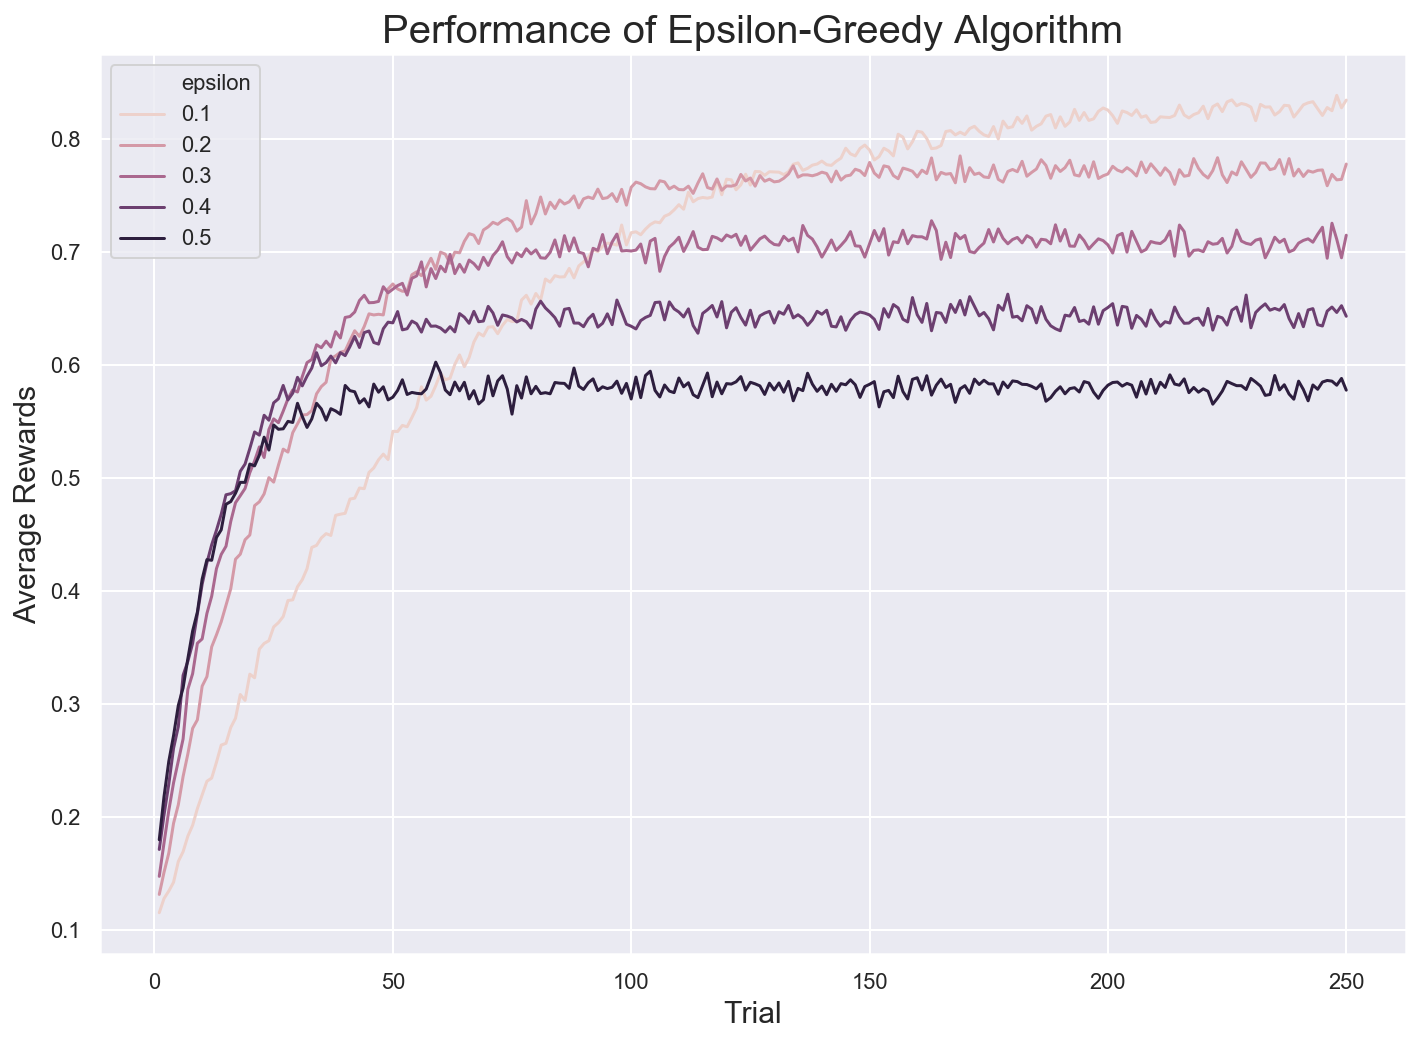

In [54]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(x="times", y="avg_rewards", hue="epsilon", legend="full", data=df_reward)
ax.set_title('Performance of Epsilon-Greedy Algorithm', fontsize=20)
ax.set_xlabel('Trial', fontsize=15)
ax.set_ylabel('Average Rewards', fontsize=15)
plt.show()

**Takeaway**:

* The curves with high values of epsilon go up very quickly, but then peak out. If epsilon is high, we explore a lot and find the best arm quickly, but then we keep exploring even after it’s not worth doing anymore. When epsilon is high, our system’s peak performance is fairly low.
* Low epsilons causes the algorithm to explore much more slowly, but eventually the algorithm reaches a much higher peak performance level.
* The settings that lead to lots of exploration learn quickly, but don’t exploit often enough at the end; whereas the settings that lead to little exploration learn slowly, but do well at the end.

> **Approach 2: Track the Cumulative Reward at Each Point in Time**

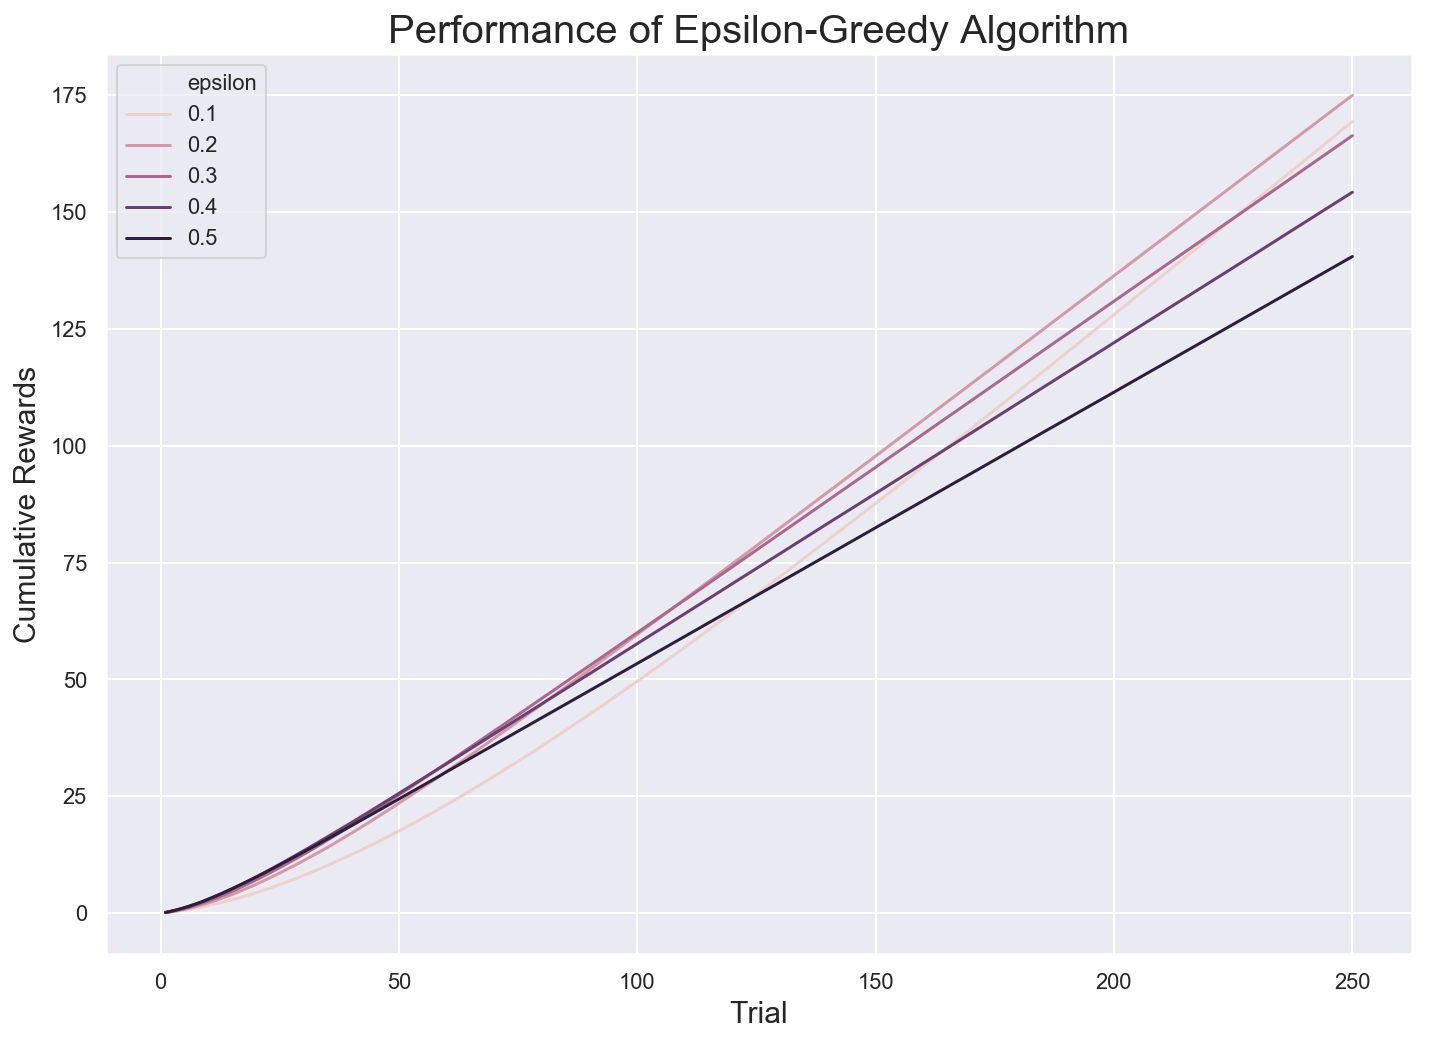

In [51]:
ax = sns.lineplot(x="times", y="cumulative_rewards", hue="epsilon", legend="full", data=df_reward)
ax.set_title('Performance of Epsilon-Greedy Algorithm', fontsize=20)
ax.set_xlabel('Trial', fontsize=15)
ax.set_ylabel('Cumulative Rewards', fontsize=15)
plt.show()

**Takeaway**:

* Looking at the cumulative results, you can see that curves for the low value of epsilon = 0.1 and the high value of epsilon = 0.5 intersect after about 130 rounds: before then, it was good to have explored a lot, but after then it was better to have been able to exploit more consistently once the algorithm had found the best arm.
* The algorithm does eventually figure out which arm is best no matter how epsilon is set. But the length of time required to figure our which arm is best depends a lot on the value of epsilon.

## <a id='cons'>The Cons of Epsilon-Greedy Algorithm</a>

* As the algorithm reach a point that it is almost certain which option is the best, explore more options become more wasteful. In the jargon of bandit algorithms, you’ll be over-exploring. Epsilon-Greedy algorithm doesn't take this into account
* If we fix the epsilon to be 10%, at the start of your experimentation, you’ll choose options that you don’t know much about far more rarely than you’d like to because you only try new options 10% of the time. This is basically a trade of between explore & exploit. There are some other ways to improve upon this algorithm by using weighted average.

## <a id='refer'>Reference</a>

* Online Book- Bandit Algorithms for Website Optimization
    * [Chapter 3. The epsilon-Greedy Algorithm](https://learning.oreilly.com/library/view/bandit-algorithms-for/9781449341565/ch03.html)
    * [Chapter 4. Debugging Bandit Algorithms](https://learning.oreilly.com/library/view/bandit-algorithms-for/9781449341565/ch04.html)
* [Medium Post: Solving the Multi Armed Bandit Problem](https://towardsdatascience.com/solving-the-multi-armed-bandit-problem-b72de40db97c)
* [Seaborn lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html)